## Persistent homology - Vietoris-Rips filtration

One aspect of spatial data which is becoming more widely recognised as important is the <i>topology</i> of data. Topology, broadly speaking, is a mathematical discipline which describes key features of a surface that don't change as the surface is deformed (with apologies to any topologists who dislike this description...). Under these deformations, certain key properties of data are preserved; numbers of connected components, holes in the surface, empty "voids" in a 3D dataset, and so on. While traditionally studied by pure mathematicians, recently Topological Data Analysis has emerged as field through which datasets can be characterised using their topological features.

In this tutorial, we briefly introduce some key concepts from Topological Data Analysis (TDA), and show how MuSpAn can be used to calculate the <i>persistent homology</i> of point data.

First, let's load in the `Synthetic-Points-Architecture` dataset as an example.

MuSpAn domain loaded successfully. Domain summary:
Domain name: Architecture
Number of objects: 5991
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []


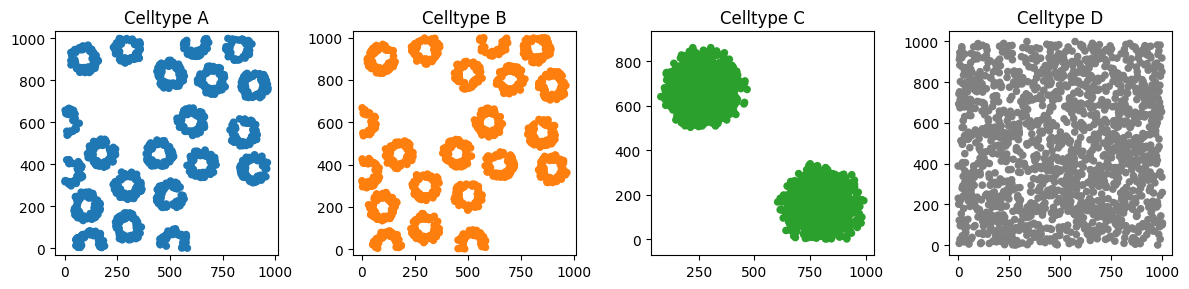

In [1]:
import muspan as ms 
import matplotlib.pyplot as plt

# Load the example domain dataset
domain = ms.datasets.load_example_domain('Synthetic-Points-Architecture')

# Define the cell types to visualize
celltypes = ['A', 'B', 'C', 'D']

# Create a figure with subplots for each cell type
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

# Loop through each cell type and visualize it
for i, cell in enumerate(celltypes):
    ms.visualise.visualise(domain, 'Celltype', objects_to_plot=('Celltype', cell), ax=axes[i], add_cbar=False)
    axes[i].set_title(f'Celltype {cell}')

# Display the plot
plt.show()

This synthetic dataset has some interesting features that can be well characterised by their topology. For example, the Celltype C cells are arranged into two distinct blobs - while none of the cell centres within these blobs are touching, they qualitatively appear to us to be two distinct features. 

Defining methods which can quantify that there are two distinct features in the set of Celltype C points is a specialty of TDA. One canonical method for doing this is to use persistent homology (PH) to describe the points. The key insight of PH is to consider different length scales at which the points might be connected. Let's dive into this idea into a bit more (extremely non-technical) detail.

Let's zoom in on one of the blobs (just so that the points aren't too small to see). Suppose we connect any points which are separated by distance $r$, for some value of $r$.

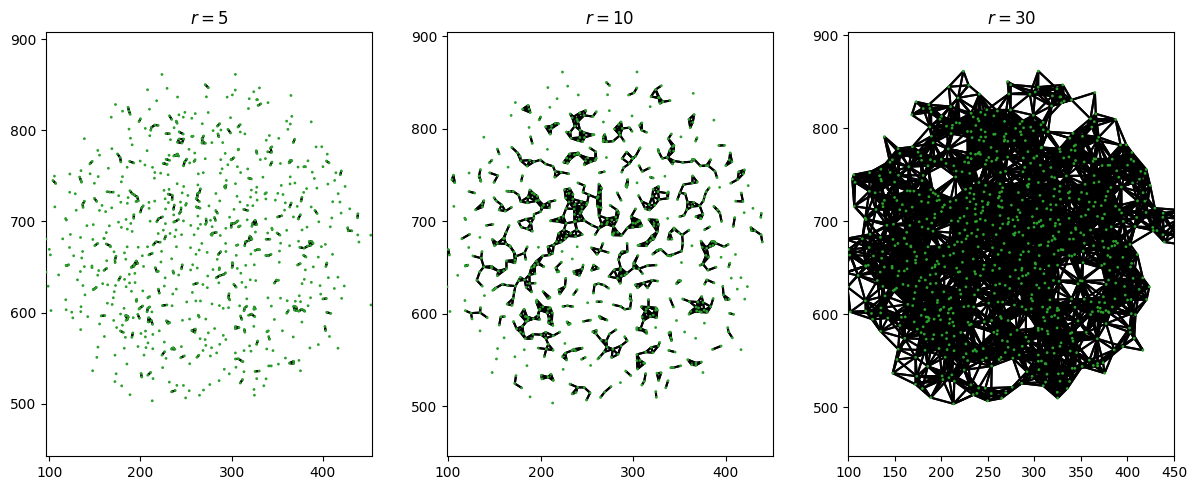

In [2]:
# Calculate the distance matrix between all Celltype C objects
d = ms.helpers.object_to_object_distance_matrix(domain, ('Celltype', 'C'), ('Celltype', 'C'))

# Get the centroids of Celltype C objects
centroids, _ = ms.query.get_centroids(domain, ('Celltype', 'C'))

# Import necessary modules
import numpy as np
from matplotlib.collections import LineCollection

# Create a figure with subplots for different values of r
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Define the different values of r to visualize
rs = [5, 10, 30]

# Loop through each value of r and visualize the connections
for i, r in enumerate(rs):
    # Visualize the Celltype C objects
    ms.visualise.visualise(domain, 'Celltype', objects_to_plot=('Celltype', 'C'), ax=axes[i], add_cbar=False, marker_size=1)
    
    # Get all pairs of objects separated by less than r
    mask = d < r
    inds_a, inds_b = np.where(mask)
    
    # Exclude self measurements
    to_exclude = inds_a == inds_b
    inds_a = inds_a[~to_exclude]
    inds_b = inds_b[~to_exclude]
    
    # Get the coordinates of the connected pairs
    c1 = centroids[inds_a, :]
    c2 = centroids[inds_b, :]
    
    # Create line segments for the connections
    segs = [[(c1[v, 0], c1[v, 1]), (c2[v, 0], c2[v, 1])] for v in range(len(c1))]
    ln_coll = LineCollection(segs, colors=['k' for v in segs])
    
    # Add the line segments to the plot
    axes[i].add_collection(ln_coll)
    
    # Set the limits and title for the plot
    axes[i].set_xlim([100, 450])
    axes[i].set_ylim([500, 850])
    axes[i].set_title(f'$r = {r}$')

# Display the plot
plt.show()

When $r$ is small, this is mostly just lots of very disconnected points. For $r=0$, none of the points would be connected, and we'd have each point living in its own connected component. As $r$ gets bigger, we see the blob joining up more and more (fewer connected components). Finally, when $r$ is big, the points become fully connected and we finally get one single connected component for the entire blob.

Unfortunately, we can't count the number of blobs by just taking a really big value of $r$ and counting the number of connected components. Let's zoom out and look at the whole domain at once, with some different values of $r$.

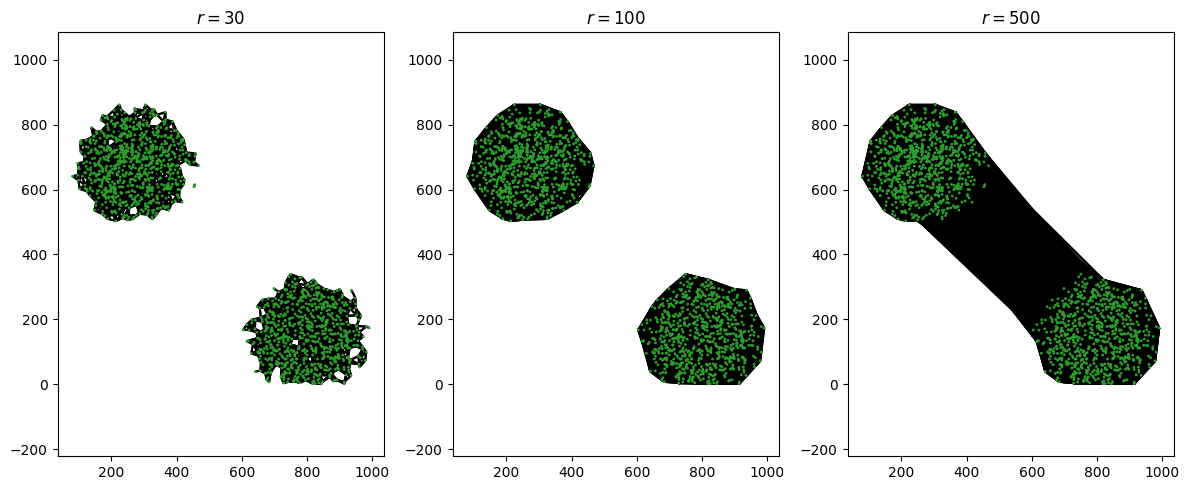

In [3]:
# Calculate the distance matrix between all Celltype C objects
d = ms.helpers.object_to_object_distance_matrix(domain, ('Celltype', 'C'), ('Celltype', 'C'))

# Get the centroids of Celltype C objects
centroids, _ = ms.query.get_centroids(domain, ('Celltype', 'C'))

# Import necessary modules
import numpy as np
from matplotlib.collections import LineCollection

# Create a figure with subplots for different values of r
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Define the different values of r to visualize
rs = [30, 100, 500]

# Loop through each value of r and visualize the connections
for i, r in enumerate(rs):
    # Visualize the Celltype C objects
    ms.visualise.visualise(domain, 'Celltype', objects_to_plot=('Celltype', 'C'), ax=axes[i], add_cbar=False, marker_size=1)
    
    # Get all pairs of objects separated by less than r
    mask = d < r
    inds_a, inds_b = np.where(mask)
    
    # Exclude self measurements
    to_exclude = inds_a == inds_b
    inds_a = inds_a[~to_exclude]
    inds_b = inds_b[~to_exclude]
    
    # Get the coordinates of the connected pairs
    c1 = centroids[inds_a, :]
    c2 = centroids[inds_b, :]
    
    # Create line segments for the connections
    segs = [[(c1[v, 0], c1[v, 1]), (c2[v, 0], c2[v, 1])] for v in range(len(c1))]
    ln_coll = LineCollection(segs, colors=['k' for v in segs])
    
    # Add the line segments to the plot
    axes[i].add_collection(ln_coll)
    
    # Set the title for the plot
    axes[i].set_title(f'$r = {r}$')

# Display the plot
plt.show()

We can see the start of a "goldilocks" effect here. If we make $r$ too small, it doesn't quite match our intuition of what the data looks like: for $r=30$, we see two distinct large connected components, but there are still a few outlier dots that aren't connected to either. When $r=100$, the connected components match our intuition. But when $r=500$, we only have one connected component - the two blobs have joined up with one another.

This isn't quite how PH works (sorry, we said it'd be a non-technical introduction), but it's close. Essentially, in PH we vary this parameter $r$ to form a <i>filtration</i>, and we measure the number of connected components as $r$ goes from 0 to infinity (or, practically, the value at which all points are connected). There are many complex rules about how points can be joined together; here, we consider a rule called the <i>Vietoris-Rips</i> filtration, which [connects points using roughly the rule we've considered here](https://en.wikipedia.org/wiki/Vietoris%E2%80%93Rips_complex).

Once again, apologies to any topologists reading this.

So how does PH using the Vietoris-Rips filtration describe our data? In essence, as we increase $r$ we keep track of both the number of connected components and the number of holes in the surface formed by connecting all the points. (There are some - ok, lots - of subtleties we're skipping here, but hopefully you get the idea for an introductory tutorial). Whenever a feature (connected component, known as an $H_0$ feature; or void, known as an $H_1$ feature) is formed, we say that this feature is "born" at the corresponding $r$ value. When $r$ gets large enough a feature can also "die", either because the hole has "closed up" or because two connected components have merged together.

Let's run the process on our blobs of Celltype C, and plot the "birth" and "death" of each feature on a graph:

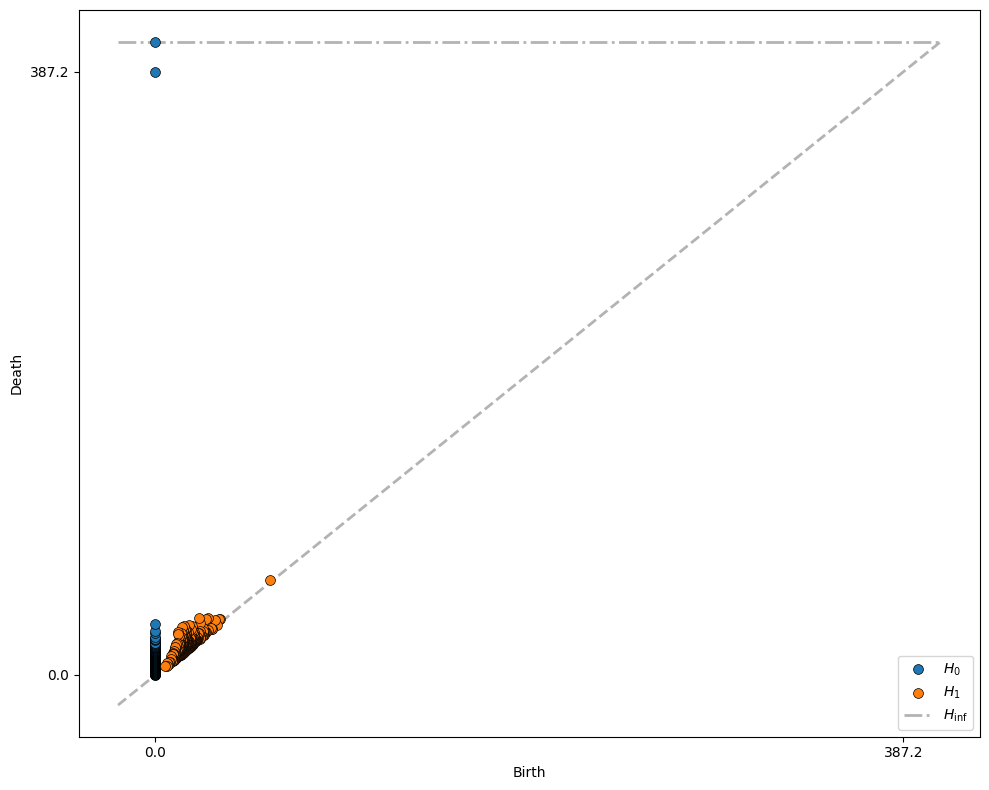

In [4]:
# Perform Vietoris-Rips filtration on Celltype C and visualize the output
output = ms.topology.vietoris_rips_filtration(domain, ('Celltype', 'C'), visualise_output=True)

# The output contains the persistence diagram which shows the birth and death of each feature
# This helps us understand the topological features of the Celltype C data

This graph contains all the key information about the birth and death of each feature. How do we interpret it? First, let's focus on the blue circles that represent the $H_0$ features (connected components). All connected component features are born at $r=0$, since initially each point is a distinct component. Most of them die at very small values of $r$, representing the distance from each point to its nearby neighbours. However, two of the $H_0$ features <i>persist</i> for a large range of $r$, being born at $r=0$ and not disappearing until $r=387.2$ (and, for the second, never disappearing - we will always be left with one connected component, so for every dataset one component dies "at infinity").

These two "highly persistent" features represent the two blobs in our data! In general, the key insight of PH is that features which persist over a large range of $r$ values are likely to be more important. In this way, we don't need to choose a "goldilocks" length scale that's just right for our data - we consider all possible length scales of connection, and identify key features as those that persist.

Turning our attention to the orange $H_1$ features, we see that there are no especially persistent features - most loops in the green blobs "die" very soon after they are "born". Let's instead repeat this analysis on Celltype A.

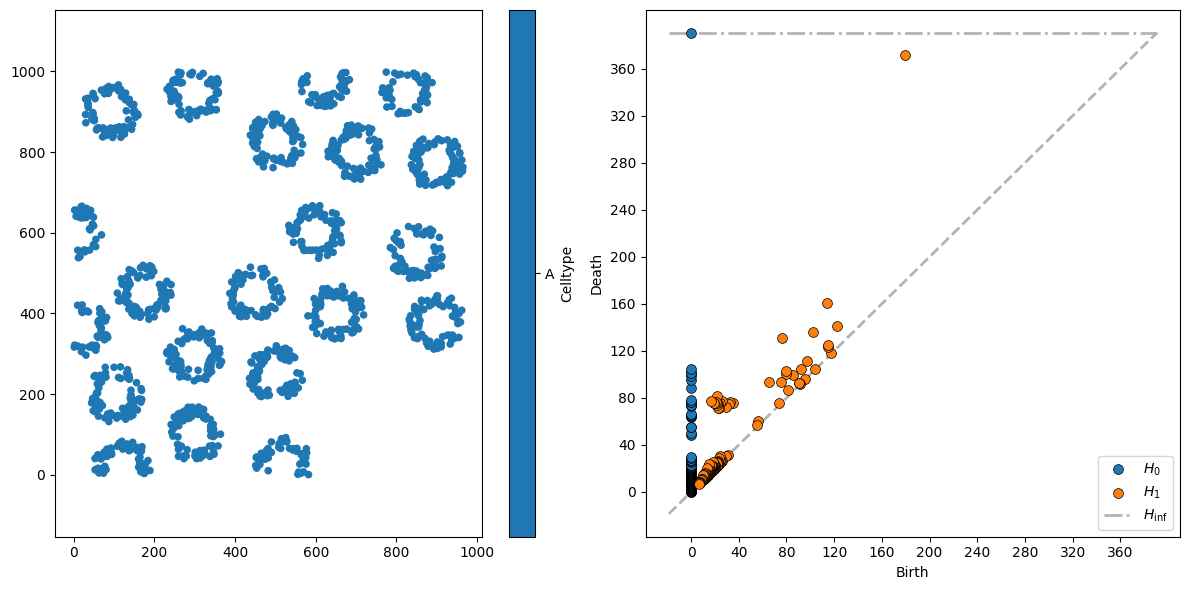

In [5]:
# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Visualize Celltype A objects in the first subplot
ms.visualise.visualise(domain, 'Celltype', objects_to_plot=('Celltype', 'A'), ax=axes[0])

# Perform Vietoris-Rips filtration on Celltype A and visualize the persistence diagram in the second subplot
output = ms.topology.vietoris_rips_filtration(
    domain, 
    ('Celltype', 'A'), 
    visualise_output=True, 
    visualise_peristence_diagram_kwargs={'ax': axes[1]}
)

# Set custom ticks for the x and y axes of the persistence diagram
_ = axes[1].set_xticks([40 * v for v in range(10)])
_ = axes[1].set_yticks([40 * v for v in range(10)])

This is a little more interesting. The 21 "circle" structures are seen as slightly more persistent $H_0$ features, dying for $r$ between 50 and 120. 

For $H_1$ features, there are a couple of interesting persistent clusters. The first cluster, of loops born at $r \approx 20$ and dying at $r \approx 80$, are the circular structures in the dataset (with a characteristic diameter of around 80 units).

The second set of interesting loops here are the $H_1$ features born at $80 \lessapprox r \lessapprox 120$ - these are "loops" formed by adjacent crypts joining up. Finally, the most persistent loop - with birth at $r \approx 200$ and death at $r \approx 370$ - is the large void formed in the top left of the image, where the cluster of Celltype C cells is.

This way of visualising the data is called a <i>persistence diagram</i>, and is a standard way of representing data in TDA. A common way of using this data is to <i>vectorise</i> it and pass this output to, for instance, [machine learning pipelines](https://doi.org/10.1101/2024.01.05.574362). MuSpAn makes this easy - simply pass the output from the Vietoris-Rips calculation into the `ms.topology.vectorise_persistence()` function to obtain a feature vector.